In [1]:
import numpy as np
from scipy import signal
from scipy.interpolate import interp1d
from scipy.signal import butter, filtfilt, iirdesign, zpk2tf, freqz
import scipy.fftpack as sfft

In [2]:
%matplotlib notebook

In [3]:
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from matplotlib.colors import Normalize
import h5py
from tqdm import tqdm_notebook as tqd
import readligo as rl

#### Import the LIGO files 

In [4]:
fn_H1 = 'L-L1_GWOSC_16KHZ_R1-1186741846-32.hdf5'
strain_H1, time_H1, chan_dict_H1 = rl.loaddata(fn_H1, 'L1')

# sampling rate:
fs = 16384

tevent = 1186741861.5

true_chirp_mass = 24.2

readligo.py:132: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  shortnameArray = dqInfo['DQShortnames'].value
readligo.py:138: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  injnameArray = injInfo['InjShortnames'].value
readligo.py:143: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  gpsStart = meta['GPSstart'].value


In [5]:
#both H1 and L1 have the same time 
time = time_H1

#the time sample interval
dt = time[1] - time[0]

deltat = 5

In [6]:
def plot_raw(strain, tevent, deltat, time):
    indxt = np.where((time >= tevent-deltat) & (time < tevent+deltat))
    
    plt.figure()
    plt.plot(time[indxt]-tevent, strain[indxt])
    plt.xlabel('time (s) since ' + str(tevent))
    plt.ylabel("Strain")
    plt.title("Raw LIGO strain data")

<IPython.core.display.Javascript object>


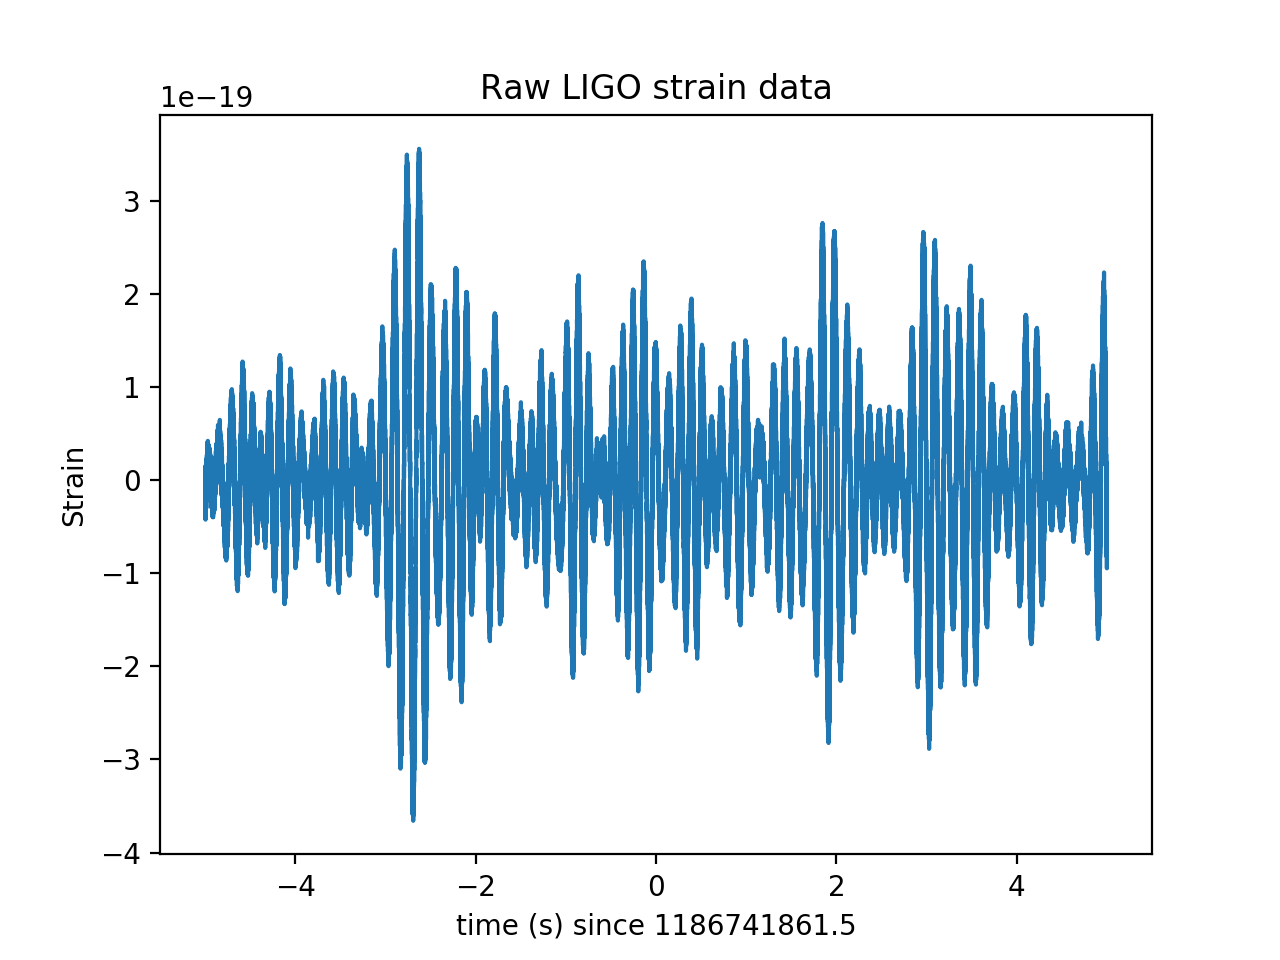

In [7]:
plot_raw(strain_H1, tevent, deltat, time_H1)

#### Start cleaning the data

In [8]:
def asd(strain, NFFT, fmin, fmax):
    Pxx, freqs = mlab.psd(strain, Fs=fs, NFFT=NFFT)
    psd = interp1d(freqs, Pxx)
    return psd, Pxx, freqs

In [9]:
NFFT = 1*fs
fmin = 10
fmax = 2000

psd, Pxx, freqs = asd(strain_H1, NFFT, fmin, fmax)

<IPython.core.display.Javascript object>


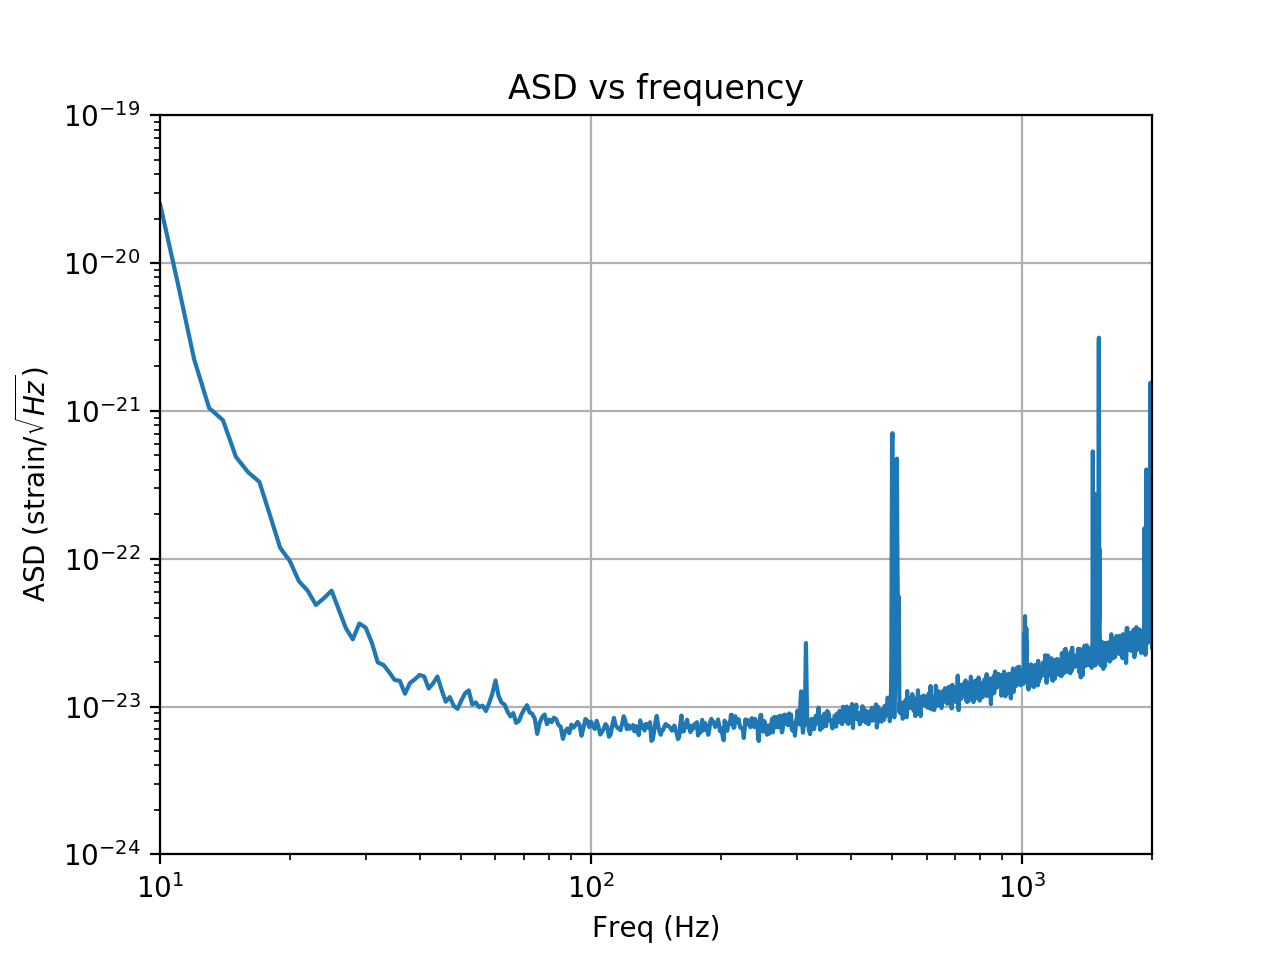

Text(0.5,1,'ASD vs frequency')

In [10]:
plt.figure()
plt.loglog(freqs, np.sqrt(Pxx))
plt.axis([fmin, fmax, 1e-24, 1e-19])
plt.grid()
plt.ylabel(r"ASD (strain/$\sqrt{Hz}$)")
plt.xlabel("Freq (Hz)")
plt.title("ASD vs frequency")

### Now a funciton to "whiten" the data

We will divide the data by the magnitude of the noise frequencies, supressing the low frequency noise. 

In [11]:
def whiten(strain, interp_psd, dt):
    Nt = len(strain)
    freqs = np.fft.rfftfreq(Nt, dt)
    
    #whitening: transform to the frequency domain, 
    #   divide by the asd, then transform back, taking
    #   care to get the normalization right
    hf = np.fft.rfft(strain)
    white_hf = hf / (np.sqrt(interp_psd(freqs) /dt/2.0))
    white_ht = np.fft.irfft(white_hf, n=Nt)
    return white_ht

In [12]:
strain_H1_whiten = whiten(strain_H1, psd, dt)

### Now it is time for bandpassing

Bandpassing is a method of passing on frequencies within a certain range and rejecting those outside

In [13]:
def bandpass(strain, fs):
    bb, ab = butter(4, [20.0*2/fs, 300.0*2/fs], btype="band")
    strain_bp = filtfilt(bb, ab, strain)
    return strain_bp

In [14]:
strain_H1_whiten_bp = bandpass(strain_H1_whiten, fs)

## Now let's look at the data

We should be able to see the actual gravitational wave signal

<IPython.core.display.Javascript object>


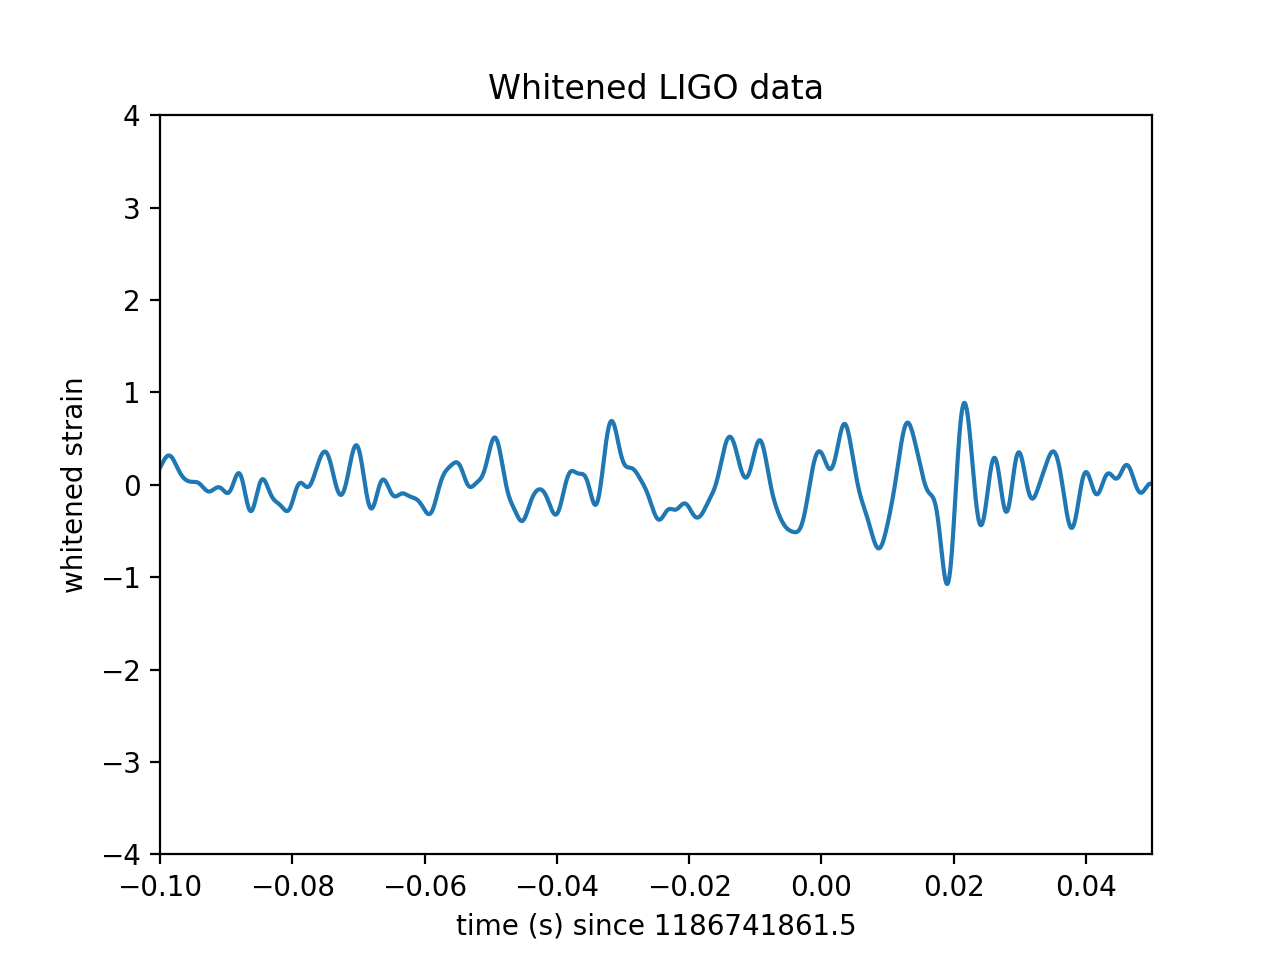

Text(0.5,1,'Whitened LIGO data')

In [15]:
tmin = -0.1
tmax = 0.05
plt.figure()
plt.plot(time-tevent, strain_H1_whiten_bp)
plt.xlim(tmin, tmax)
plt.ylim(-4,4)
plt.xlabel("time (s) since " + str(tevent))
plt.ylabel("whitened strain")
plt.title("Whitened LIGO data")

### Now to look at the signal using a spectrogram

In [16]:
# plot the whitened data, zooming in on the signal region
deltat = 0.5

# index into the strain time series for this time interval
indxt = np.where((time_H1 >= tevent-deltat) & (time_H1 < tevent+deltat))

NFFT = fs/16
NOVL = NFFT*15/16
window = np.blackman(NFFT)

<IPython.core.display.Javascript object>


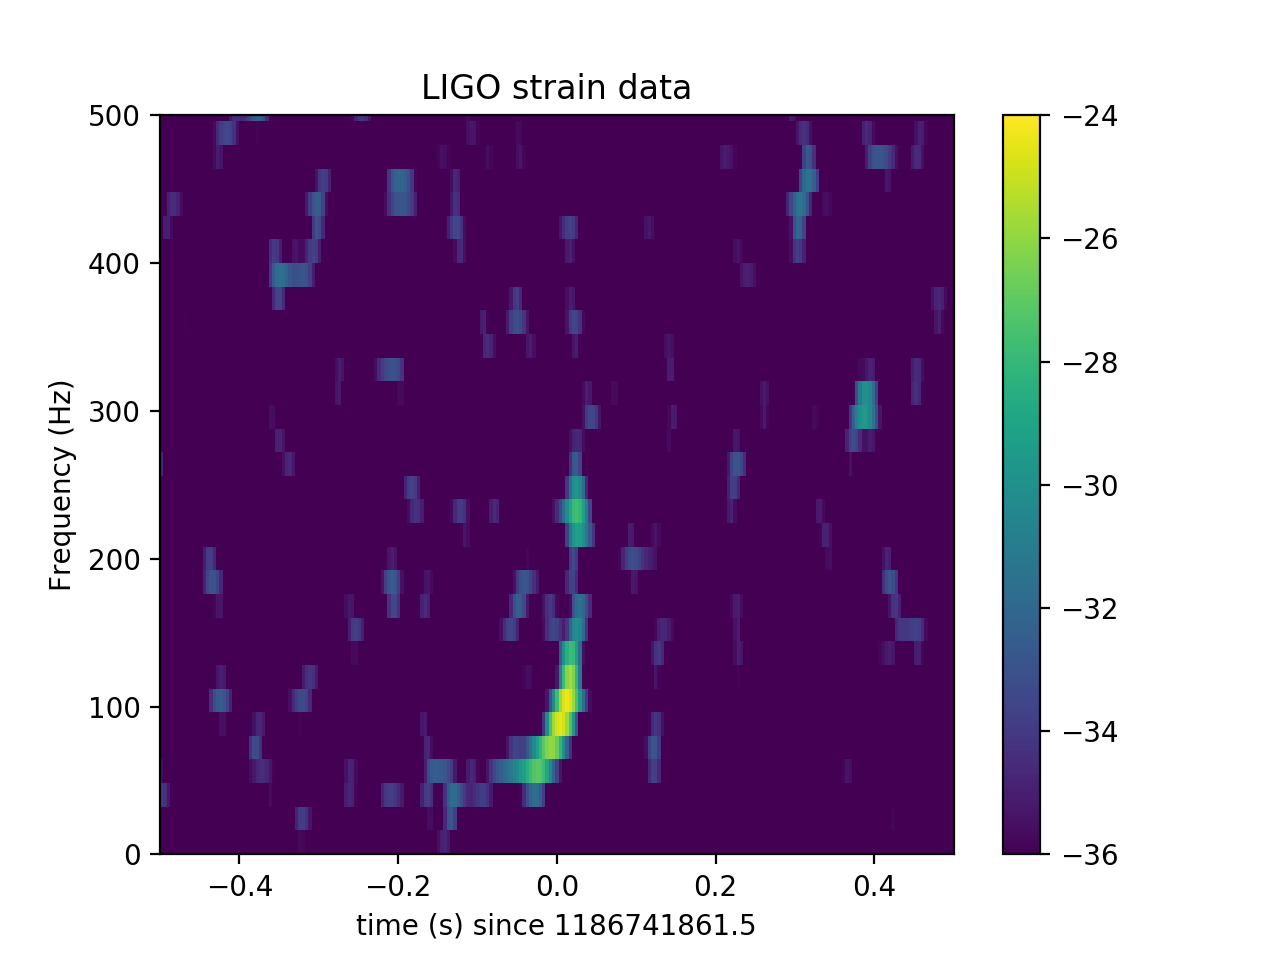

Text(0.5,1,'LIGO strain data')

In [17]:
plt.figure()
spec_H1, freqs, bins, im = plt.specgram(strain_H1_whiten[indxt], NFFT=NFFT, Fs=fs, window=window, noverlap=NOVL, cmap='viridis', xextent=[-deltat,deltat], norm=Normalize(-36,-24))
plt.xlabel('time (s) since ' + str(tevent))
plt.ylabel("Frequency (Hz)")
plt.colorbar()
plt.axis([-0.5, 0.5, 0, 500])
plt.title("LIGO strain data")

### Functions to help find the dominant frequency in a given interval

In [18]:
def max_value(arr):
    '''
    This function takes in an array and returns the 
    index of the entry with the maximum value
    '''
    max_val = np.amax(arr)
    max_indx= np.where(arr == max_val)
    return max_indx

In [19]:
def spike_frequency(freqs, fourier_transform, mag=False):
    '''
    This function takes in the raw fourier transform by default 
    and picks out the dominant frequency
    
    If being passed the magnitude, set mag=True
    '''
    if mag:
        pos = max_value(fourier_transform)
        return freqs[pos[0][0]]
    pos = max_value(np.abs(fourier_transform))
    return freqs[pos[0][0]]

In [20]:
def fourier_transform_freq_time(data, start_indx, interval, fs, dt):
    '''
    This function takes in an array of data, a start index, and an interval 
    on which to perform a fourier transform and returns the dominant 
    frequency as well as the midpoint time for the interval 
    '''
    start = start_indx
    stop = start_indx+interval
    data = sfft.fft(data[start:stop])
    freqs= sfft.fftfreq(interval)*fs
    
    spike_freq = spike_frequency(freqs, data)
    
    time = (stop*dt + start*dt)/2
    return time, spike_freq

In [21]:
def transform_loop(data, interval, time_arr, freq_arr, fs, dt):
    '''
    This function takes in a large array of data and an interval on which 
    to perform many small interval fourier transforms to, and returns 
    the time and dominant frequency for each interval
    '''
    for start_index in tqd(range(len(data)-interval), leave=False, desc=str(interval)):
        time, freq = fourier_transform_freq_time(data, start_index, interval, fs, dt)
        time_arr.append(time)
        freq_arr.append(freq)
        start_index = start_index + interval/16
    return time_arr, freq_arr

In [22]:
intervals = [1000, 500, 300, 250, 150]#, 75]
time_arr = []
freq_arr = []

for interval in tqd(intervals, leave=False, desc="interval"):
    transform_loop(strain_H1_whiten[indxt], interval, time_arr, freq_arr, fs, dt)
    


/Users/DanielBautista/opt/miniconda3/envs/ligo-py27/lib/python2.7/site-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


SEJveChjaGlsZHJlbj0oRmxvYXRQcm9ncmVzcyh2YWx1ZT0wLjAsIGRlc2NyaXB0aW9uPXUnaW50ZXJ2YWwnLCBtYXg9NS4wLCBzdHlsZT1Qcm9ncmVzc1N0eWxlKGRlc2NyaXB0aW9uX3dpZHTigKY=


/Users/DanielBautista/opt/miniconda3/envs/ligo-py27/lib/python2.7/site-packages/ipykernel_launcher.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  import sys


SEJveChjaGlsZHJlbj0oRmxvYXRQcm9ncmVzcyh2YWx1ZT0wLjAsIGRlc2NyaXB0aW9uPXUnMTAwMCcsIG1heD0xNTM4NC4wLCBzdHlsZT1Qcm9ncmVzc1N0eWxlKGRlc2NyaXB0aW9uX3dpZHTigKY=


SEJveChjaGlsZHJlbj0oRmxvYXRQcm9ncmVzcyh2YWx1ZT0wLjAsIGRlc2NyaXB0aW9uPXUnNTAwJywgbWF4PTE1ODg0LjAsIHN0eWxlPVByb2dyZXNzU3R5bGUoZGVzY3JpcHRpb25fd2lkdGjigKY=


SEJveChjaGlsZHJlbj0oRmxvYXRQcm9ncmVzcyh2YWx1ZT0wLjAsIGRlc2NyaXB0aW9uPXUnMzAwJywgbWF4PTE2MDg0LjAsIHN0eWxlPVByb2dyZXNzU3R5bGUoZGVzY3JpcHRpb25fd2lkdGjigKY=


SEJveChjaGlsZHJlbj0oRmxvYXRQcm9ncmVzcyh2YWx1ZT0wLjAsIGRlc2NyaXB0aW9uPXUnMjUwJywgbWF4PTE2MTM0LjAsIHN0eWxlPVByb2dyZXNzU3R5bGUoZGVzY3JpcHRpb25fd2lkdGjigKY=


SEJveChjaGlsZHJlbj0oRmxvYXRQcm9ncmVzcyh2YWx1ZT0wLjAsIGRlc2NyaXB0aW9uPXUnMTUwJywgbWF4PTE2MjM0LjAsIHN0eWxlPVByb2dyZXNzU3R5bGUoZGVzY3JpcHRpb25fd2lkdGjigKY=


In [23]:
time_arr = np.asarray(time_arr)
freq_arr = np.asarray(freq_arr)

<IPython.core.display.Javascript object>


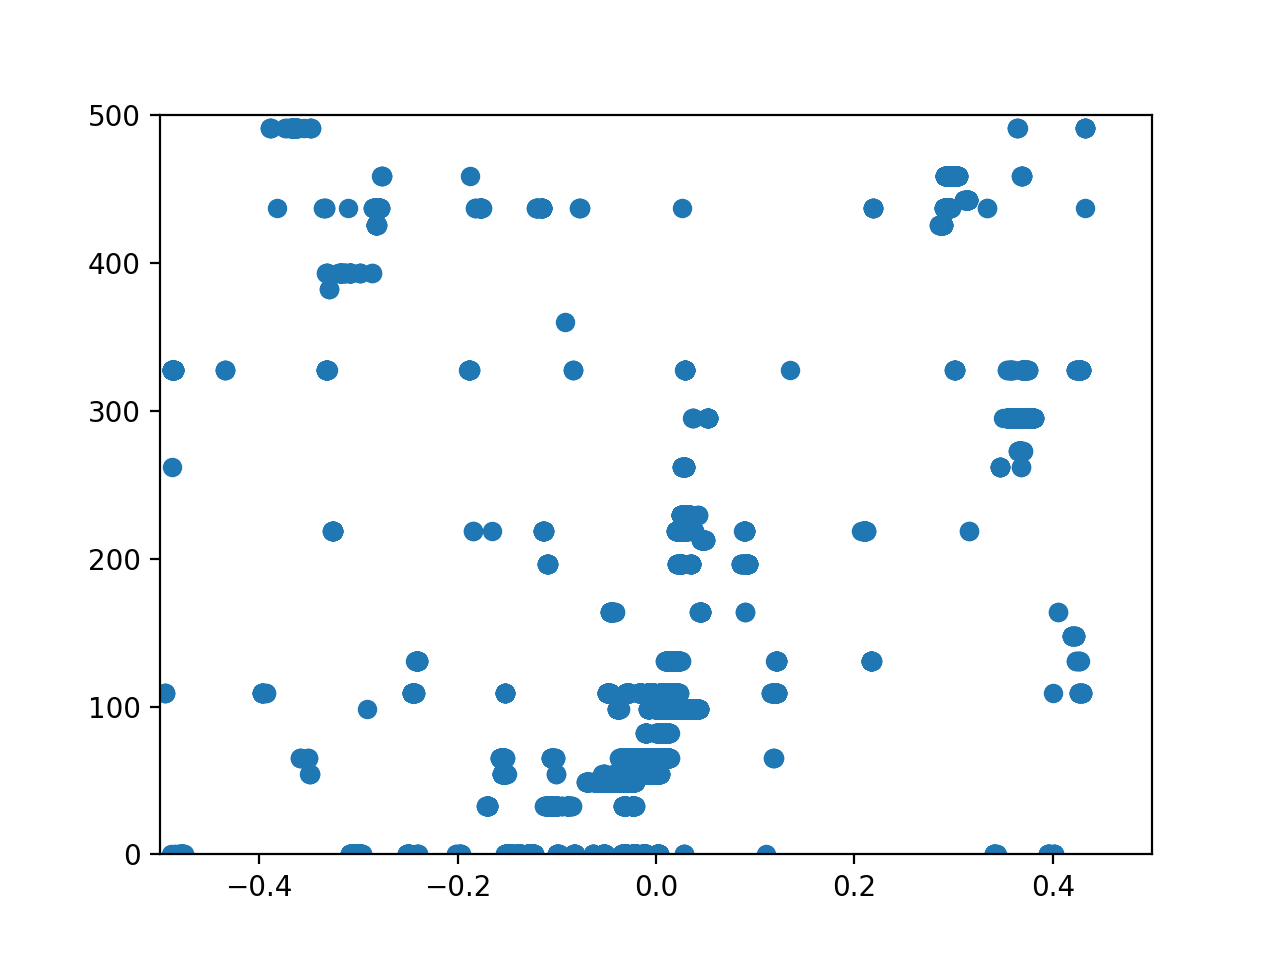

[-0.5, 0.5, 0, 500]

In [24]:
plt.figure()
plt.scatter(time_arr-deltat, np.abs(freq_arr))
plt.axis([-0.5, 0.5, 0, 500])

### Now let's look at this overlayed on the spectrogram

<IPython.core.display.Javascript object>


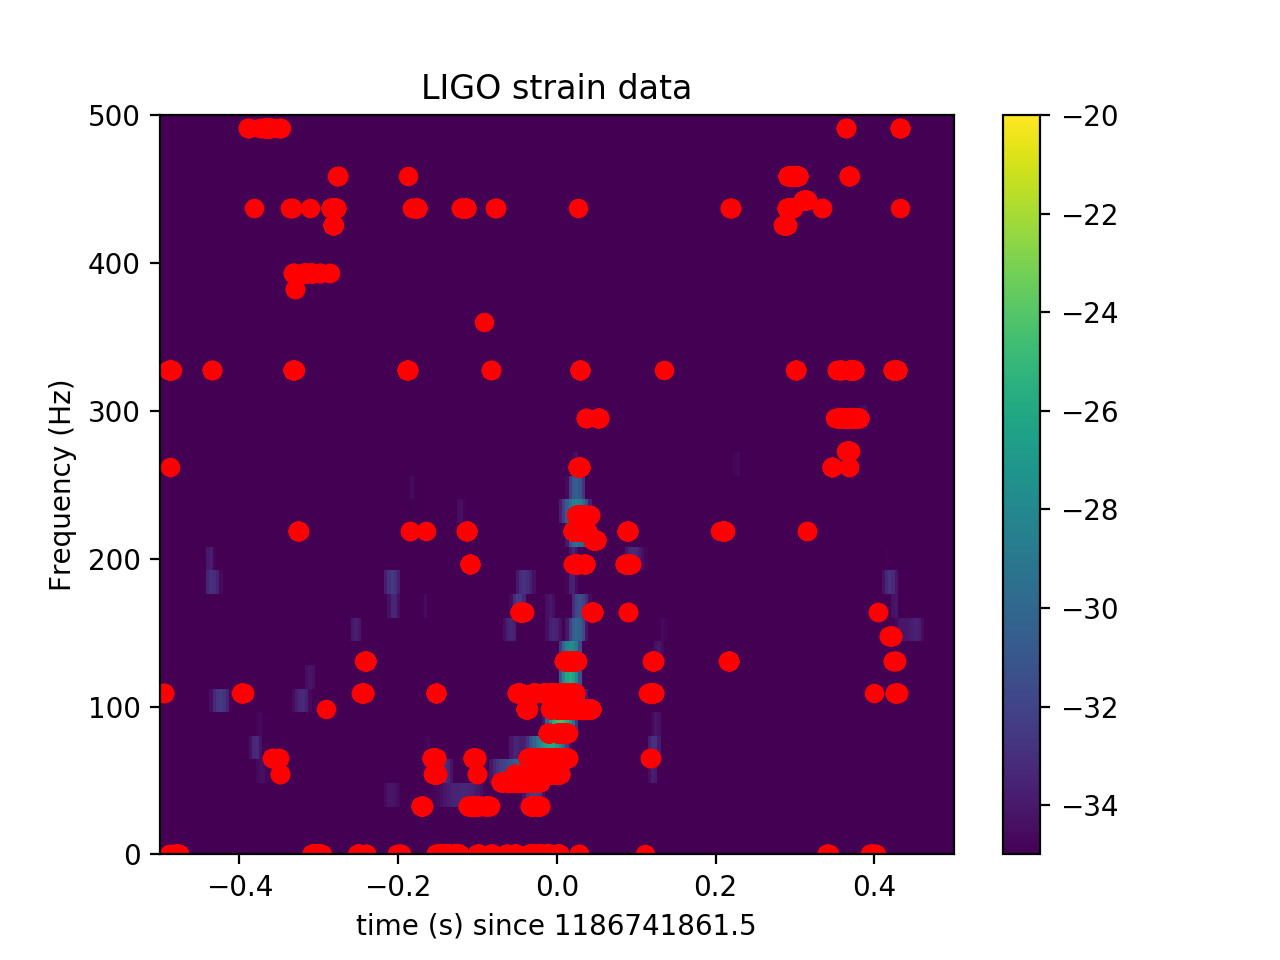

In [25]:
plt.figure()
spec_H1, freqs, bins, im = plt.specgram(strain_H1_whiten_bp[indxt], NFFT=NFFT, Fs=fs, window=window, noverlap=NOVL, cmap='viridis', xextent=[-deltat,deltat], norm=Normalize(-35,-20))
plt.xlabel('time (s) since ' + str(tevent))
plt.ylabel("Frequency (Hz)")
plt.colorbar()
plt.axis([-0.5, 0.5, 0, 500])
plt.title("LIGO strain data")

plt.scatter(time_arr-deltat, np.abs(freq_arr), color='r')

#### The data looks good! 

I just need to do some cleaning of the data 

In [26]:
def trim(time_arr, freq_arr, deltat, tmin, tmax, fmax):
    interval = np.where((time_arr >= deltat+tmin) & (time_arr < deltat+tmax))
    time_arr = time_arr[interval]
    freq_arr = freq_arr[interval]
    
    to_remove = []
    for i in range(len(time_arr)):
        if freq_arr[i] <= 0 or freq_arr[i] > fmax:
            to_remove.append(i)
            
    time_arr = np.delete(time_arr, to_remove)
    freq_arr = np.delete(freq_arr, to_remove)
    
    return time_arr, freq_arr

In [27]:
new_time, new_freq = trim(time_arr, freq_arr, deltat, tmin, tmax, 300)

#### The data has been trimmed down

Let's see how it looks

<IPython.core.display.Javascript object>


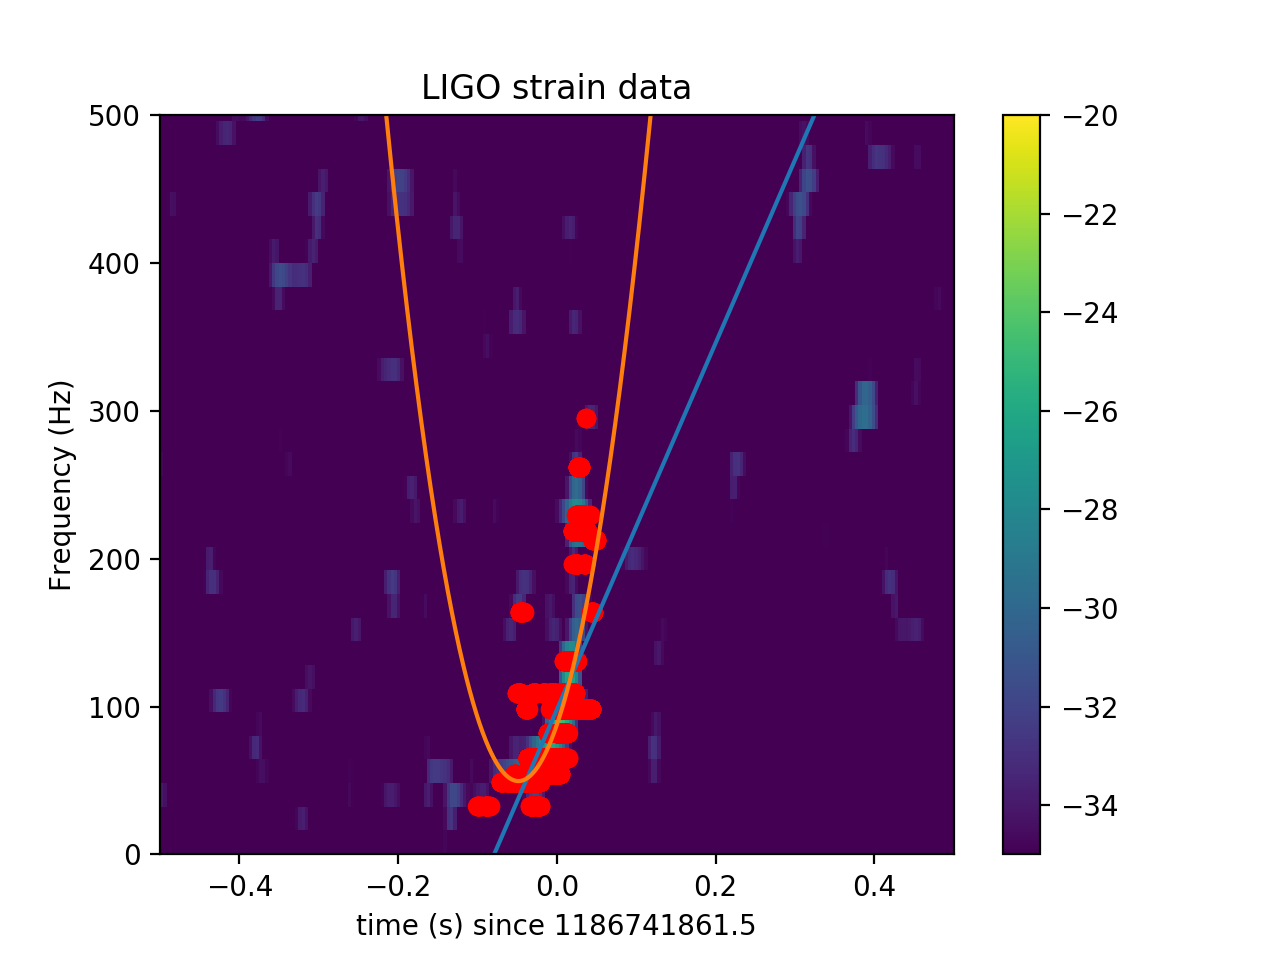

Text(0.5,1,'LIGO strain data')

In [28]:
plt.figure()
spec_H1, freqs, bins, im = plt.specgram(strain_H1_whiten[indxt], NFFT=NFFT, Fs=fs, window=window, noverlap=NOVL, cmap='viridis', xextent=[-deltat,deltat], norm=Normalize(-35,-20))
plt.colorbar()
plt.scatter(new_time-deltat, np.abs(new_freq), color='r')
plt.xlabel('time (s) since ' + str(tevent))
plt.ylabel("Frequency (Hz)")
plt.axis([-0.5, 0.5, 0, 500])
plt.title("LIGO strain data")

#plt.scatter(new_time-deltat, np.abs(new_freq), color='r')

## That is very good

Now it is time to try to fit a line to it 

In [29]:
t = np.linspace(-0.5, 0.5, 1000)
m1, b1 = np.polyfit(new_time-deltat, new_freq, 1)
y1 = m1*t + b1

plt.plot(t, y1)

It fits alright, but is fairly off in some parts. Let's try a second order curve now

In [30]:
a, b, c = np.polyfit(new_time-deltat, new_freq, 2)
y2 = a*t*t + b*t + c

plt.plot(t, y2)

In [31]:
def chirp_mass(frq, dfdt):
    c = 3.0e8
    G = 6.67e-11
    m_sun = 1.989e30
    
    chirp_mass = (c**3.0/G) * ((5.0/96.0) * np.pi**(-8.0/3.0) * frq**(-11.0/3.0) * dfdt)**(3.0/5.0)
    return chirp_mass/m_sun

In [32]:
def derive_frequency(a, b, c, m):
    x = (m-b)/(2*a)
    f = a*x**2 + b*x + c
    return f

In [33]:
def percent_err(true, result):
    percent = np.abs(true-result)*100/true
    return percent

In [34]:
value_freq = derive_frequency(a,b,c,m1)
value_slope= m1

In [35]:
chirp_mass = chirp_mass(value_freq, value_slope)
chirp_mass

31.38194865464299

In [36]:
percent_err(true_chirp_mass, chirp_mass)

29.67747377951649